In [1]:
import torch
import torch.nn as nn
from torch import optim

from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
train = pd.read_csv('D:\\Dropbox\\GitHub\\deepstudy\\ko\\data\\train.csv')
X_test = pd.read_csv('D:\\Dropbox\\GitHub\\deepstudy\\ko\\data\\test (1).csv')
y_test = pd.read_csv('D:\\Dropbox\\GitHub\\deepstudy\\ko\\data\\y_test.csv')

In [12]:
train.Pclass = train.Pclass.astype('category')
train.Embarked = train.Embarked.astype('category')
train.Age = train.Age.astype('float32')
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [13]:
test = pd.concat([X_test, y_test], axis=1)
test.Pclass = test.Pclass.astype('category')
test.Age = test.Age.astype('float32')
test.Embarked = test.Embarked.astype('category')

test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
train[['Age', 'Embarked']] = imputer.fit_transform(train[['Age', 'Embarked']])
test[['Age', 'Embarked']] = imputer.transform(test[['Age', 'Embarked']])

In [15]:
add_train = pd.get_dummies(train[['Pclass', 'Sex', 'Embarked']])
add_test = pd.get_dummies(test[['Pclass', 'Sex', 'Embarked']])

train = pd.concat([train, add_train], axis=1)
test = pd.concat([test, add_test], axis=1)

train.drop(['Pclass', 'Sex', 'Embarked'], axis=1, inplace=True)
test.drop(['Pclass', 'Sex', 'Embarked'], axis = 1, inplace = True)

In [16]:
X = train.drop('Survived', axis = 1)
y = train.Survived

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size = 0.2, random_state=2023)

In [19]:
X_train.Age = X_train.Age.astype('float32')
X_train.Fare = X_train.Fare.astype('float32')

X_val.Age = X_val.Age.astype('float32')
X_val.Fare = X_val.Fare.astype('float32')

In [21]:
X_train = torch.Tensor(X_train.values)
X_val = torch.Tensor(X_val.values)
y_train = torch.Tensor(y_train.values)
y_val = torch.Tensor(y_val.values)

In [23]:
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

In [26]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DNN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(500, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [28]:
model = DNN(X_train.shape[1], 1)

loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch: 0, Loss: 1.1276934146881104
Epoch: 100, Loss: 0.13266286253929138
Epoch: 200, Loss: 0.3687034845352173
Epoch: 300, Loss: 0.4183879494667053
Epoch: 400, Loss: 0.12913432717323303


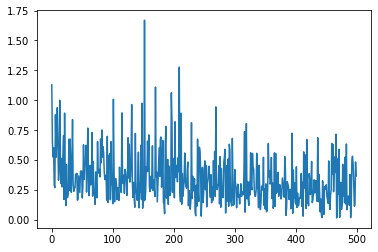

In [30]:
num_epochs = 500
train_loss_list = []

for epoch in range(num_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_func(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    train_loss_list.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

plt.plot(train_loss_list)


In [32]:
torch.save(model.state_dict(), 'weights.pt')

In [34]:
model.load_state_dict(torch.load('weights.pt'))
model

DNN(
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=500, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

In [84]:
y_pred_lst = []
acc_lst = []
with torch.no_grad():
    model.eval()
    for X, y in val_loader:
        y_pred = model(X)
        y_pred = (y_pred > 0.5).float()
        y_pred_lst.append(y_pred)
        acc = (y_pred == y.unsqueeze(1)).float().mean()
        acc_lst.append(acc)
        print(f'Accuracy: {acc.item()}')

print(f'Average Accuracy: {sum(acc_lst)/len(acc_lst)}')
    


Accuracy: 0.90625
Accuracy: 0.84375
Accuracy: 0.6875
Accuracy: 0.59375
Accuracy: 0.90625
Accuracy: 0.8947368264198303
Average Accuracy: 0.8053727746009827


In [88]:
test.Age = test.Age.astype('float32')
X_test = test.drop('Survived', axis=1)
y_test = test.Survived

X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values)



In [90]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred > 0.5).float()
    acc = (y_pred == y_test.unsqueeze(1)).float().mean()
    print(f'Accuracy: {acc.item()}')
    

Accuracy: 0.8468899726867676
